In [44]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [45]:
dataset = pd.read_csv('../data/child_master_file.csv')

In [46]:
"""
This is a list of all numerical varaibles that were initially proposed
Some were dropped because of multicollinearity

 ['v101','v102','v103','v104','v105','v106','v107','v108','v109','v110', 'v113',
                            'v116','v117','v118','v128','v129','v130','v131','v132','v133','v138','v139','v140',
                           'v142','v144','v146']
"""

selectedCategoricalColumns = ['age_group','w5_best_marstt','educat','w5_geo2011','w5_best_race','w5_empl_stat',
                   'w5_hhead_gen','water_source','w5_h_enrgelec','cooking_energy','hhsize_grp','w5_h_dwltyp']


selectedNumericalColumns = ['v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109',
       'v110', 'v113', 'v116', 'v130','v132','v133','v139','v146']


target = dataset['died'].astype('int')

selectedCategories = dataset[selectedCategoricalColumns].astype('O')

selectedNumerics = dataset[selectedNumericalColumns].astype('int64','float64')

selectedDataset = selectedCategories.join(selectedNumerics, how='outer')

In [47]:
#separating categories
categoricals = selectedDataset.select_dtypes(include='object')
# Take k-1 dummies out of k categorical levels, drop_first set to true
categoricals = pd.get_dummies(categoricals, drop_first=True)

#numerics can be normalized separately
numerics = selectedDataset.select_dtypes(include=['int64','float64'])
selectedDataset = categoricals.join(numerics)

#joining numerics with categories again
dataset = selectedDataset.join(target, how='outer')

In [48]:
"""
This function is for handling class imbalances
we undersampled the minority class
"""
def underSample_dataPrepation(df):
    #-counts the distribution of target variable
    target_count = df.died.value_counts()
    y = df.loc[:, 'died']
    X = df.iloc[:, 0:dataset.shape[1]-1]
    df_class_0 = df[df['died'] == 0]
    df_class_1 = df[df['died'] == 1]
    #-oversampling the lowest class to make it equivalent to the majority class
    df_class_0_under = df_class_0.sample(target_count[1], replace=True)
    #-concatenate the targets after oversampling
    data_train = pd.concat([df_class_1, df_class_0_under], axis=0)
    target_count_2 = data_train.died.value_counts()
    print('Class 0:', target_count_2[0])
    print('Class 1:', target_count_2[1])
    print('Proportion:', round(target_count_2[0] / target_count_2[1], 2), ': 1')
    
    x_labels = data_train.loc[:, 'died']
    x_features = data_train.iloc[:, 0:dataset.shape[1]-1]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.3)
    
    print("length of training data")
    print(len(x_features_train))
    print("length of test data")
    print(len(x_features_test))
    
    return (data_train, x_features_train, x_features_test, x_labels_train, x_labels_test)
dataset, X_train, X_test, y_train, y_test = underSample_dataPrepation(dataset)

Class 0: 149
Class 1: 149
Proportion: 1.0 : 1
length of training data
208
length of test data
90


In [49]:
X = dataset.iloc[:,:-1]
y = dataset['died'].values

In [50]:
"""
Fitting Random Forest Classification to the Training set
with the parameters shown below. NOTE: Take note of parameter tuning
"""
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(
 n_estimators='warn', 
 criterion='gini', 
 max_depth=None, 
 min_samples_split=2, 
 min_samples_leaf=1, 
 min_weight_fraction_leaf=0.0, 
 max_features='auto', 
 max_leaf_nodes=None, 
 min_impurity_decrease=0.0, 
 min_impurity_split=None, 
 bootstrap=True, 
 oob_score=False, 
 n_jobs=None, 
 random_state=None, 
 verbose=0, 
 warm_start=False,
)
    
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [51]:
import collections
collections.Counter(y_pred)

#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
confusion

array([[25, 16],
       [27, 22]], dtype=int64)

In [52]:
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)
accuracy

0.5222222222222223

In [53]:
from sklearn import metrics
print("Sensitivity")
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred))
print("**********************************************")
print("Specificity")
print(TN / float(TN + FP))

Sensitivity
0.4489795918367347
0.4489795918367347
**********************************************
Specificity
0.6097560975609756


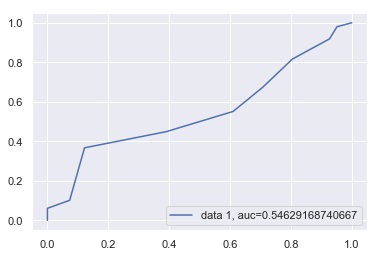

In [54]:
target_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, target_pred_proba)
auc = metrics.roc_auc_score(y_test,  target_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [55]:
# This is cell is for shap values
row_to_show = 10
data_for_prediction =  X_train.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
classifier.predict_proba(data_for_prediction_array)

array([[0.7, 0.3]])

In [56]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(classifier)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

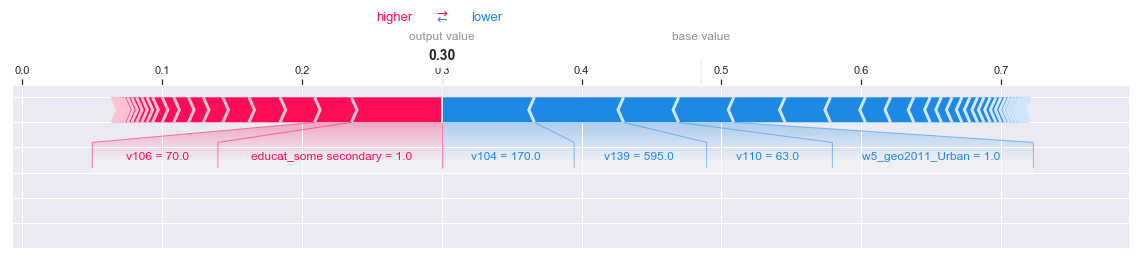

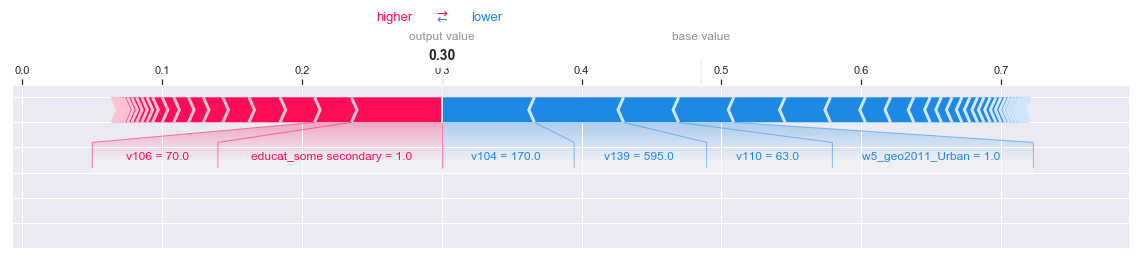

In [59]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction, matplotlib=True, show=False)
# plt.savefig('../images/forceplot.pdf',bbox_inches='tight')